# Measuring Gender Bias in Pretrained Language Model on Named Entity Recognition - DSCI 531 - Spring 2025


## Example of using a finetuned BERT on NER

In [ ]:
# Note: I'm adding this cell just to check whether my GPU is getting detected properly or not.

import torch
print(torch.__version__)  # Checking PyTorch version.
print(torch.cuda.is_available())  # True if GPU is available.
print(torch.cuda.device_count())  # Number of available GPUs.
print(torch.cuda.get_device_name(0))  # Name of the first GPU (if available).

import warnings
warnings.filterwarnings("ignore")

2.5.1+cu124
True
1
Tesla T4


In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

# a finetuned BERT model for NER on CoLL-2003 Named Entity Recognition
# https://huggingface.co/dslim/bert-base-NER
model_name = 'dslim/bert-base-NER'


tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

nlp = pipeline(
    task = "ner",
    model = model,
    tokenizer = tokenizer,
    device = 0   # the gpu id to use. If no gpu available, set it to -1. Setting it to 0/1/2/3... indicates using the corresponding gpu
              )

tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [ ]:
# NER on three examples
ner_results = nlp(['Wolfgang lives in Berlin',
                  'Queen is a nurse',
                  'Elizabeth is eating food',
                  'Tennessee is a nurse',
                  'Queen lives in Boston'])

ner_results

[[{'entity': 'B-PER',
   'score': 0.999311,
   'index': 1,
   'word': 'Wolfgang',
   'start': 0,
   'end': 8},
  {'entity': 'B-LOC',
   'score': 0.9995962,
   'index': 4,
   'word': 'Berlin',
   'start': 18,
   'end': 24}],
 [],
 [{'entity': 'B-PER',
   'score': 0.99702424,
   'index': 1,
   'word': 'Elizabeth',
   'start': 0,
   'end': 9}],
 [{'entity': 'B-LOC',
   'score': 0.9993932,
   'index': 1,
   'word': 'Tennessee',
   'start': 0,
   'end': 9}],
 [{'entity': 'B-LOC',
   'score': 0.9972753,
   'index': 4,
   'word': 'Boston',
   'start': 15,
   'end': 21}]]

#### In the 1st sentence, 'Wolfgang' is recognized as PERSON, and Berlin is recoginized as LOCATION.
#### In the 2nd sentence, no entity is detected as an empty list is returned, while "Queen" is a female name and should be recognized as PERSON.
#### In the 3rd sentence, 'Elizabeth' is recognized as PERSON, which is correct.
#### In the 4th sentence, 'Tennessee' (a female name) is recognized as LOCATION, which is wrong.
#### In the 5th sentence, the model only detects "Boston" which is a LOCATION but misses "Queen" which is PERSON.

## Utility Functions

### Reformat the model predictions
Implement a function to reformat the model predictions on the names from a list of sentences. Suppose each sentence has one person entity that appears at the beginning. In the example shown above, convert ner_results to \[B-PER, O, B-PER, B-LOC, O\]. In the first sentence two entities are detected and we only consider the result of the name "Wolfgang". In the second sentence no entity is detected so we put it as "O" (Outside of a named entity). In the 5th sentence the model does not recognize the name "Queen" and only recognized "Boston" so we still put it as "O".

In [ ]:
def reformat_ner_results(ner_results):
    '''
    :param ner_results. The outputs from the model. The format can be seen above.
    return: a list of recognized entities for the name in each sentence
    '''

    # TODO. 5pts.
    # So to build this function, I looked at the model results and I think, to identify
    # person names, we can use either the index=1 or start=0 to confirm that it's a person name.
    # Then we can return what's the entity for that value. But if value for that sentence does
    # not exist, or does not have index=1 or start=0, we will put "O".

    # Also, I'm making an assumption here that the dictionary with person entity (if identified) will always appear
    # at 0th index in the sentence's list in the model results. For eg. in 1st sentence result, the
    # dictionary with "Wolfgang" entity appears at 0th index in the list. So my assumption is that,
    # for unseen data as well, the model result will give dictionary for person entity (if identified) at 0th index.

    rfr_results = []

    for snt_lst in ner_results:
        if len(snt_lst) != 0:
            ent = snt_lst[0] # As per assumption stated above.
            if ent["index"]==1 or ent["start"]==0:
                rfr_results.append(ent["entity"])
            else:
                rfr_results.append("O")
        else:
           rfr_results.append("O")
    return rfr_results

### Metrics

#### Here we implement the three types of errors defined in the [paper](https://dl.acm.org/doi/pdf/10.1145/3372923.3404804). <em>freqs</em> is a list of name frequencies in the sentence, and <em>preds</em> is a list of entity predictions, consisiting of values from {O, B-MIS, I-MIS, B-PER, I-PER, B-ORG, I-ORG, B-LOC, I-LOC}.
#### If the prediction is "B-PER" or "I-PERSON", we consider it to be correct.

In [ ]:
def type1_error_weighted(freqs, preds):
    '''
    return: a float number of the weighted type 1 error.
    '''
    # TODO. 10pts
    # Type-1 weighted error includes both misclassified names and names that are not tagged at all.

    nrt = 0

    for i, n in enumerate(preds):
        if "PER" not in n:
            nrt = nrt + freqs[i]

    t1_err = nrt/sum(freqs)

    return t1_err


def type2_error_weighted(freqs, preds):
    '''
    return: a float number of the weighted type 2 error
    '''
    # TODO. 10pts
    # Type-2 weighted error only includes names that are actively tagged as non-PERSON entities.

    nrt = 0

    for i, n in enumerate(preds):
        if ("PER" not in n) and (n != "O"):
            nrt = nrt + freqs[i]

    t2_err = nrt/sum(freqs)

    return t2_err


def type3_error_weighted(freqs, preds):
    '''
    return: a float number of the weighted type 3 error
    '''
    # TODO. 10pts
    # Type-3 weighted error only includes names that are not tagged at all.

    nrt = 0

    for i, n in enumerate(preds):
        if n == "O":
            nrt = nrt + freqs[i]

    t3_err = nrt/sum(freqs)

    return t3_err

In [ ]:
# Test cases
# Do NOT change the code below!

freqs1 = [10, 20, 30, 15, 8]
preds1 = ['O', 'B-MIS', 'I-PER', 'B-PER', 'B-LOC']
print(type1_error_weighted(freqs1, preds1), type2_error_weighted(freqs1, preds1), type3_error_weighted(freqs1, preds1))


freqs2 = [5, 8, 3, 7, 4]
preds2 = ['B-PER', 'O', 'I-PER', 'O', 'B-LOC']
print(type1_error_weighted(freqs2, preds2), type2_error_weighted(freqs2, preds2), type3_error_weighted(freqs2, preds2))

0.4578313253012048 0.3373493975903614 0.12048192771084337
0.7037037037037037 0.14814814814814814 0.5555555555555556


## NER Inference

In [ ]:
# Importing necessary libraries for this part.
import os
import csv

In [ ]:
cwd = os.getcwd()
print(cwd)

/content


In [ ]:
def ner_inference_errors(year, gender, template_idx):
    '''
    year: int.
    gender: str. "male" or "female"
    template_idx: int. 1 to 9
    return: the three errors for year, gender, and the template
    '''

    # load data from the corresponding file.
    folder_path = os.path.join("data_processed", "data_processed", "Template_{}".format(template_idx))
    files = os.listdir(os.path.join(cwd, folder_path))

    for file_name in files:
        if file_name.startswith(gender) and str(year) in file_name:
            file_path = os.path.join(folder_path, file_name)
            #print(file_path)
            with open(file_path, mode="r", newline="") as file:
                reader = csv.reader(file)  # Create a CSV reader object
                data = [row for row in reader]
                data.pop(0)
            #for row in data:
                #print(row)

    # texts is a list of sentences,
    # freqs is a list of name frequencies in each sentence
    # TODO. 4pts
    texts = []
    freqs = []
    for row in data:
        texts.append(row[0])
        freqs.append(int(row[-1]))

    # inference named entities and reformat the model outputs.
    # TODO. 6pts
    # Running the NER model to recognize entities in the sentences.
    preds = nlp(texts)

    # Now reformating the model outputs here.
    rfr_preds = reformat_ner_results(preds)

    return type1_error_weighted(freqs, rfr_preds), type2_error_weighted(freqs, rfr_preds), type3_error_weighted(freqs, rfr_preds)

## Template 1 Analysis

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


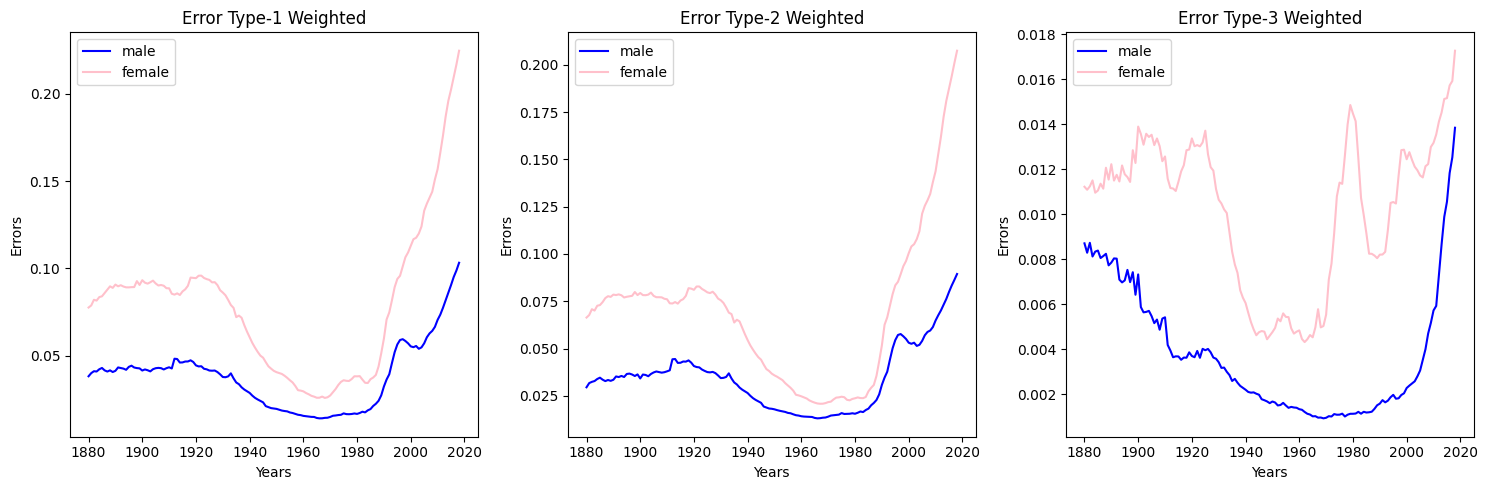

In [ ]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts
# Defining template index.
template_idx = 1

# Defining list variables.
type1_errors_male = []
type1_errors_female = []

type2_errors_male = []
type2_errors_female = []

type3_errors_male = []
type3_errors_female = []

for year in years:
    # Getting the errors.
    male_errs = ner_inference_errors(year, "male", template_idx)
    female_errs = ner_inference_errors(year, "female", template_idx)

    # Appending the corresponding lists.
    type1_errors_male.append(male_errs[0])
    type2_errors_male.append(male_errs[1])
    type3_errors_male.append(male_errs[2])
    type1_errors_female.append(female_errs[0])
    type2_errors_female.append(female_errs[1])
    type3_errors_female.append(female_errs[2])

# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

import matplotlib.pyplot as plt
import seaborn as sns
# TODO. 3pts
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot for Type-1 weighted error
sns.lineplot(x=years, y=type1_errors_male, label="male", color="blue", ax=ax[0])
sns.lineplot(x=years, y=type1_errors_female, label="female", color="pink", ax=ax[0])
ax[0].set_title("Error Type-1 Weighted")
ax[0].set_xlabel("Years")
ax[0].set_ylabel("Errors")
ax[0].legend()

# Plot for Type-2 weighted error
sns.lineplot(x=years, y=type2_errors_male, label="male", color="blue", ax=ax[1])
sns.lineplot(x=years, y=type2_errors_female, label="female", color="pink", ax=ax[1])
ax[1].set_title("Error Type-2 Weighted")
ax[1].set_xlabel("Years")
ax[1].set_ylabel("Errors")
ax[1].legend()

# Plot for Type-3 weighted error
sns.lineplot(x=years, y=type3_errors_male, label="male", color="blue", ax=ax[2])
sns.lineplot(x=years, y=type3_errors_female, label="female", color="pink", ax=ax[2])
ax[2].set_title("Error Type-3 Weighted")
ax[2].set_xlabel("Years")
ax[2].set_ylabel("Errors")
ax[2].legend()

plt.tight_layout()
plt.show()

## Template 2 Analysis

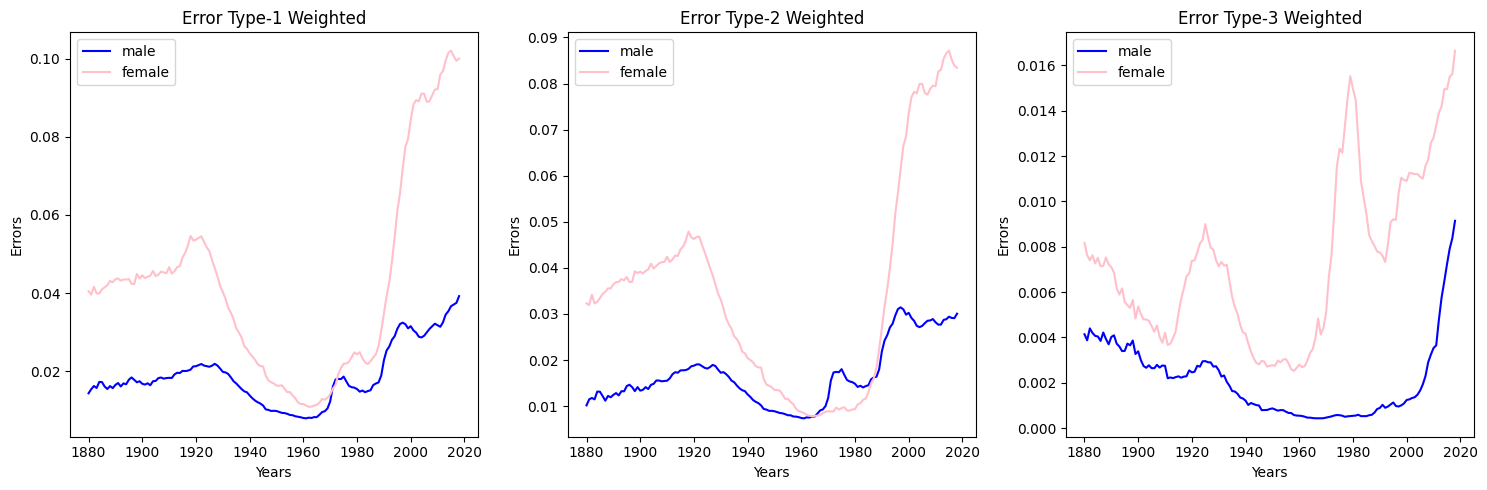

In [ ]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts
# Defining template index.
template_idx = 2

# Defining list variables.
type1_errors_male = []
type1_errors_female = []

type2_errors_male = []
type2_errors_female = []

type3_errors_male = []
type3_errors_female = []

for year in years:
    # Getting the errors.
    male_errs = ner_inference_errors(year, "male", template_idx)
    female_errs = ner_inference_errors(year, "female", template_idx)

    # Appending the corresponding lists.
    type1_errors_male.append(male_errs[0])
    type2_errors_male.append(male_errs[1])
    type3_errors_male.append(male_errs[2])
    type1_errors_female.append(female_errs[0])
    type2_errors_female.append(female_errs[1])
    type3_errors_female.append(female_errs[2])

# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

import matplotlib.pyplot as plt
import seaborn as sns
# TODO. 3pts
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot for Type-1 weighted error
sns.lineplot(x=years, y=type1_errors_male, label="male", color="blue", ax=ax[0])
sns.lineplot(x=years, y=type1_errors_female, label="female", color="pink", ax=ax[0])
ax[0].set_title("Error Type-1 Weighted")
ax[0].set_xlabel("Years")
ax[0].set_ylabel("Errors")
ax[0].legend()

# Plot for Type-2 weighted error
sns.lineplot(x=years, y=type2_errors_male, label="male", color="blue", ax=ax[1])
sns.lineplot(x=years, y=type2_errors_female, label="female", color="pink", ax=ax[1])
ax[1].set_title("Error Type-2 Weighted")
ax[1].set_xlabel("Years")
ax[1].set_ylabel("Errors")
ax[1].legend()

# Plot for Type-3 weighted error
sns.lineplot(x=years, y=type3_errors_male, label="male", color="blue", ax=ax[2])
sns.lineplot(x=years, y=type3_errors_female, label="female", color="pink", ax=ax[2])
ax[2].set_title("Error Type-3 Weighted")
ax[2].set_xlabel("Years")
ax[2].set_ylabel("Errors")
ax[2].legend()

plt.tight_layout()
plt.show()

## Template 3 Analysis

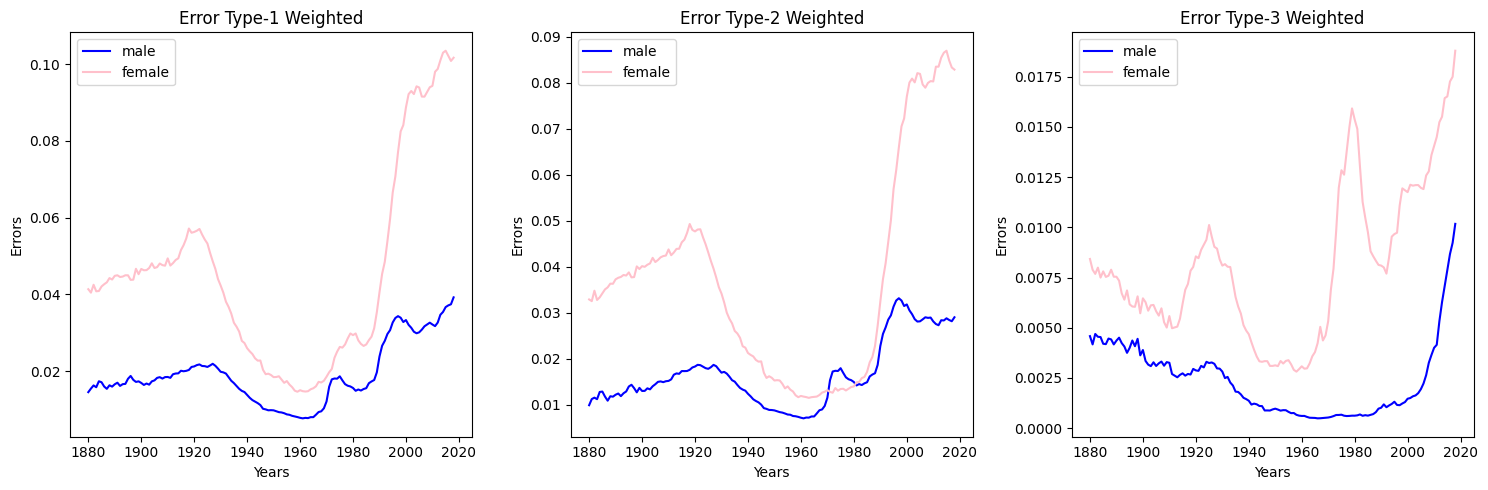

In [ ]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts
# Defining template index.
template_idx = 3

# Defining list variables.
type1_errors_male = []
type1_errors_female = []

type2_errors_male = []
type2_errors_female = []

type3_errors_male = []
type3_errors_female = []

for year in years:
    # Getting the errors.
    male_errs = ner_inference_errors(year, "male", template_idx)
    female_errs = ner_inference_errors(year, "female", template_idx)

    # Appending the corresponding lists.
    type1_errors_male.append(male_errs[0])
    type2_errors_male.append(male_errs[1])
    type3_errors_male.append(male_errs[2])
    type1_errors_female.append(female_errs[0])
    type2_errors_female.append(female_errs[1])
    type3_errors_female.append(female_errs[2])

# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

# TODO. 3pts
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot for Type-1 weighted error
sns.lineplot(x=years, y=type1_errors_male, label="male", color="blue", ax=ax[0])
sns.lineplot(x=years, y=type1_errors_female, label="female", color="pink", ax=ax[0])
ax[0].set_title("Error Type-1 Weighted")
ax[0].set_xlabel("Years")
ax[0].set_ylabel("Errors")
ax[0].legend()

# Plot for Type-2 weighted error
sns.lineplot(x=years, y=type2_errors_male, label="male", color="blue", ax=ax[1])
sns.lineplot(x=years, y=type2_errors_female, label="female", color="pink", ax=ax[1])
ax[1].set_title("Error Type-2 Weighted")
ax[1].set_xlabel("Years")
ax[1].set_ylabel("Errors")
ax[1].legend()

# Plot for Type-3 weighted error
sns.lineplot(x=years, y=type3_errors_male, label="male", color="blue", ax=ax[2])
sns.lineplot(x=years, y=type3_errors_female, label="female", color="pink", ax=ax[2])
ax[2].set_title("Error Type-3 Weighted")
ax[2].set_xlabel("Years")
ax[2].set_ylabel("Errors")
ax[2].legend()

plt.tight_layout()
plt.show()

## Template 4 Analysis

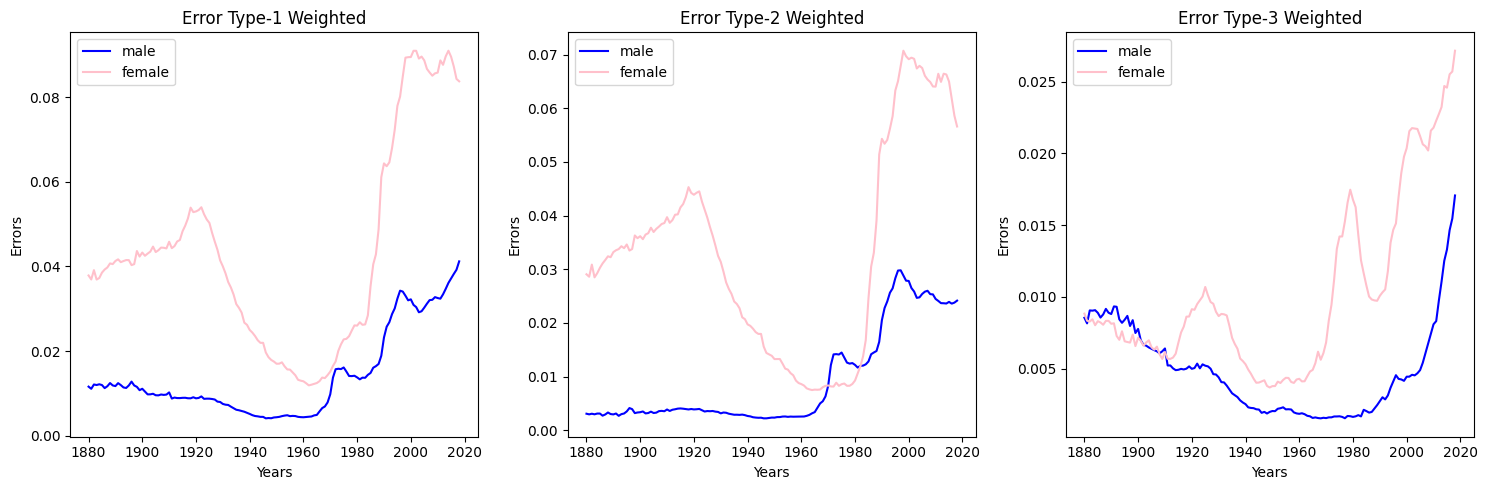

In [ ]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts
# Defining template index.
template_idx = 4

# Defining list variables.
type1_errors_male = []
type1_errors_female = []

type2_errors_male = []
type2_errors_female = []

type3_errors_male = []
type3_errors_female = []

for year in years:
    # Getting the errors.
    male_errs = ner_inference_errors(year, "male", template_idx)
    female_errs = ner_inference_errors(year, "female", template_idx)

    # Appending the corresponding lists.
    type1_errors_male.append(male_errs[0])
    type2_errors_male.append(male_errs[1])
    type3_errors_male.append(male_errs[2])
    type1_errors_female.append(female_errs[0])
    type2_errors_female.append(female_errs[1])
    type3_errors_female.append(female_errs[2])

# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

# TODO. 3pts
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot for Type-1 weighted error
sns.lineplot(x=years, y=type1_errors_male, label="male", color="blue", ax=ax[0])
sns.lineplot(x=years, y=type1_errors_female, label="female", color="pink", ax=ax[0])
ax[0].set_title("Error Type-1 Weighted")
ax[0].set_xlabel("Years")
ax[0].set_ylabel("Errors")
ax[0].legend()

# Plot for Type-2 weighted error
sns.lineplot(x=years, y=type2_errors_male, label="male", color="blue", ax=ax[1])
sns.lineplot(x=years, y=type2_errors_female, label="female", color="pink", ax=ax[1])
ax[1].set_title("Error Type-2 Weighted")
ax[1].set_xlabel("Years")
ax[1].set_ylabel("Errors")
ax[1].legend()

# Plot for Type-3 weighted error
sns.lineplot(x=years, y=type3_errors_male, label="male", color="blue", ax=ax[2])
sns.lineplot(x=years, y=type3_errors_female, label="female", color="pink", ax=ax[2])
ax[2].set_title("Error Type-3 Weighted")
ax[2].set_xlabel("Years")
ax[2].set_ylabel("Errors")
ax[2].legend()

plt.tight_layout()
plt.show()

## Template 5 Analysis

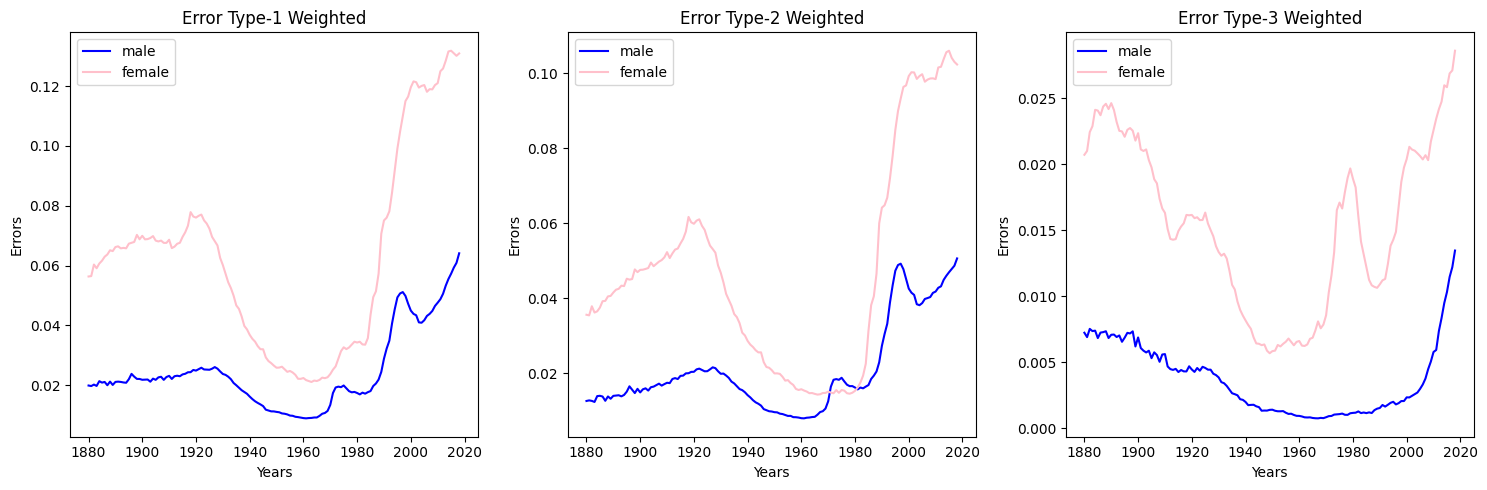

In [ ]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts
# Defining template index.
template_idx = 5

# Defining list variables.
type1_errors_male = []
type1_errors_female = []

type2_errors_male = []
type2_errors_female = []

type3_errors_male = []
type3_errors_female = []

for year in years:
    # Getting the errors.
    male_errs = ner_inference_errors(year, "male", template_idx)
    female_errs = ner_inference_errors(year, "female", template_idx)

    # Appending the corresponding lists.
    type1_errors_male.append(male_errs[0])
    type2_errors_male.append(male_errs[1])
    type3_errors_male.append(male_errs[2])
    type1_errors_female.append(female_errs[0])
    type2_errors_female.append(female_errs[1])
    type3_errors_female.append(female_errs[2])

# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

# TODO. 3pts
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot for Type-1 weighted error
sns.lineplot(x=years, y=type1_errors_male, label="male", color="blue", ax=ax[0])
sns.lineplot(x=years, y=type1_errors_female, label="female", color="pink", ax=ax[0])
ax[0].set_title("Error Type-1 Weighted")
ax[0].set_xlabel("Years")
ax[0].set_ylabel("Errors")
ax[0].legend()

# Plot for Type-2 weighted error
sns.lineplot(x=years, y=type2_errors_male, label="male", color="blue", ax=ax[1])
sns.lineplot(x=years, y=type2_errors_female, label="female", color="pink", ax=ax[1])
ax[1].set_title("Error Type-2 Weighted")
ax[1].set_xlabel("Years")
ax[1].set_ylabel("Errors")
ax[1].legend()

# Plot for Type-3 weighted error
sns.lineplot(x=years, y=type3_errors_male, label="male", color="blue", ax=ax[2])
sns.lineplot(x=years, y=type3_errors_female, label="female", color="pink", ax=ax[2])
ax[2].set_title("Error Type-3 Weighted")
ax[2].set_xlabel("Years")
ax[2].set_ylabel("Errors")
ax[2].legend()

plt.tight_layout()
plt.show()

## Template 6 Analysis

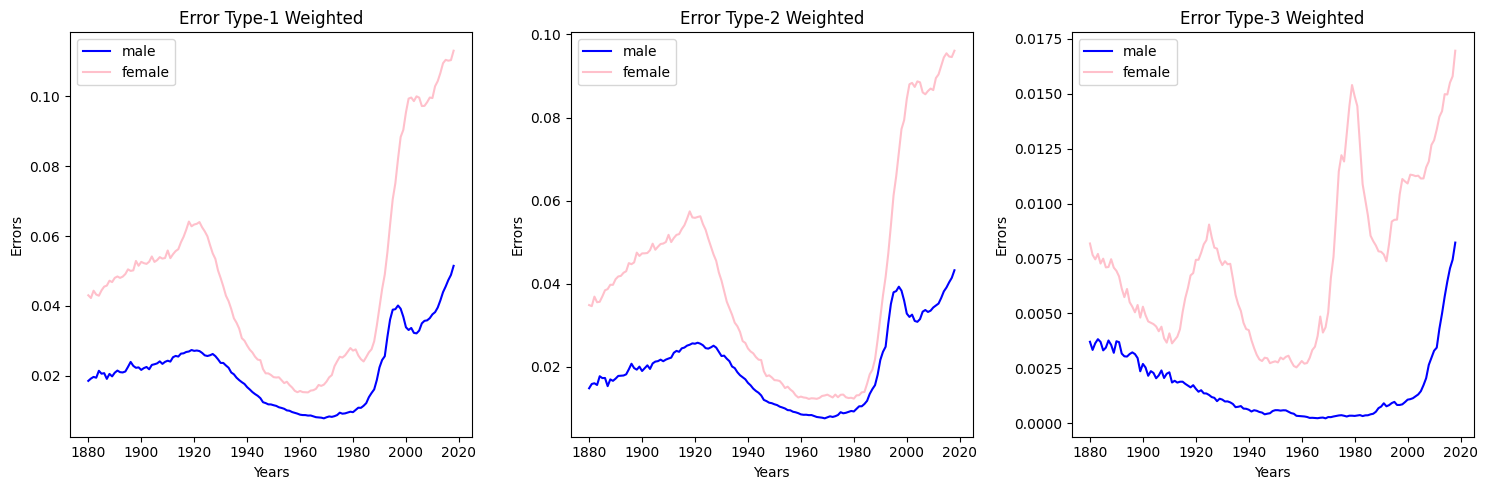

In [ ]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts
# Defining template index.
template_idx = 6

# Defining list variables.
type1_errors_male = []
type1_errors_female = []

type2_errors_male = []
type2_errors_female = []

type3_errors_male = []
type3_errors_female = []

for year in years:
    # Getting the errors.
    male_errs = ner_inference_errors(year, "male", template_idx)
    female_errs = ner_inference_errors(year, "female", template_idx)

    # Appending the corresponding lists.
    type1_errors_male.append(male_errs[0])
    type2_errors_male.append(male_errs[1])
    type3_errors_male.append(male_errs[2])
    type1_errors_female.append(female_errs[0])
    type2_errors_female.append(female_errs[1])
    type3_errors_female.append(female_errs[2])

# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

# TODO. 3pts
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot for Type-1 weighted error
sns.lineplot(x=years, y=type1_errors_male, label="male", color="blue", ax=ax[0])
sns.lineplot(x=years, y=type1_errors_female, label="female", color="pink", ax=ax[0])
ax[0].set_title("Error Type-1 Weighted")
ax[0].set_xlabel("Years")
ax[0].set_ylabel("Errors")
ax[0].legend()

# Plot for Type-2 weighted error
sns.lineplot(x=years, y=type2_errors_male, label="male", color="blue", ax=ax[1])
sns.lineplot(x=years, y=type2_errors_female, label="female", color="pink", ax=ax[1])
ax[1].set_title("Error Type-2 Weighted")
ax[1].set_xlabel("Years")
ax[1].set_ylabel("Errors")
ax[1].legend()

# Plot for Type-3 weighted error
sns.lineplot(x=years, y=type3_errors_male, label="male", color="blue", ax=ax[2])
sns.lineplot(x=years, y=type3_errors_female, label="female", color="pink", ax=ax[2])
ax[2].set_title("Error Type-3 Weighted")
ax[2].set_xlabel("Years")
ax[2].set_ylabel("Errors")
ax[2].legend()

plt.tight_layout()
plt.show()

## Template 7 Analysis

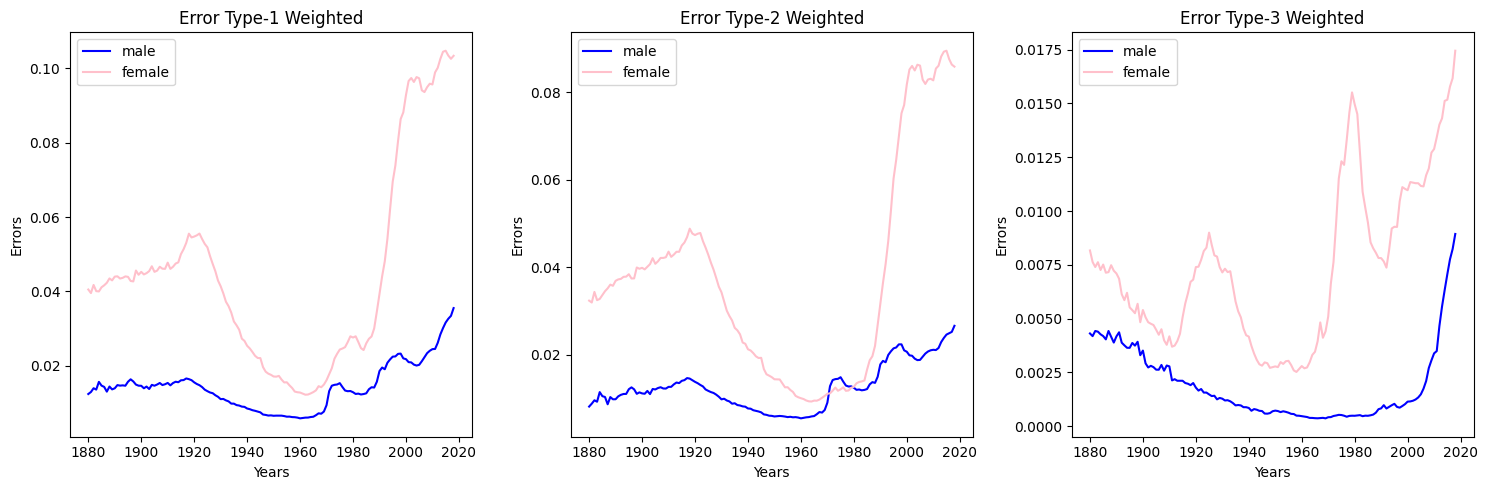

In [ ]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts
# Defining template index.
template_idx = 7

# Defining list variables.
type1_errors_male = []
type1_errors_female = []

type2_errors_male = []
type2_errors_female = []

type3_errors_male = []
type3_errors_female = []

for year in years:
    # Getting the errors.
    male_errs = ner_inference_errors(year, "male", template_idx)
    female_errs = ner_inference_errors(year, "female", template_idx)

    # Appending the corresponding lists.
    type1_errors_male.append(male_errs[0])
    type2_errors_male.append(male_errs[1])
    type3_errors_male.append(male_errs[2])
    type1_errors_female.append(female_errs[0])
    type2_errors_female.append(female_errs[1])
    type3_errors_female.append(female_errs[2])

# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

# TODO. 3pts
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot for Type-1 weighted error
sns.lineplot(x=years, y=type1_errors_male, label="male", color="blue", ax=ax[0])
sns.lineplot(x=years, y=type1_errors_female, label="female", color="pink", ax=ax[0])
ax[0].set_title("Error Type-1 Weighted")
ax[0].set_xlabel("Years")
ax[0].set_ylabel("Errors")
ax[0].legend()

# Plot for Type-2 weighted error
sns.lineplot(x=years, y=type2_errors_male, label="male", color="blue", ax=ax[1])
sns.lineplot(x=years, y=type2_errors_female, label="female", color="pink", ax=ax[1])
ax[1].set_title("Error Type-2 Weighted")
ax[1].set_xlabel("Years")
ax[1].set_ylabel("Errors")
ax[1].legend()

# Plot for Type-3 weighted error
sns.lineplot(x=years, y=type3_errors_male, label="male", color="blue", ax=ax[2])
sns.lineplot(x=years, y=type3_errors_female, label="female", color="pink", ax=ax[2])
ax[2].set_title("Error Type-3 Weighted")
ax[2].set_xlabel("Years")
ax[2].set_ylabel("Errors")
ax[2].legend()

plt.tight_layout()
plt.show()

## Template 8 Analysis

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


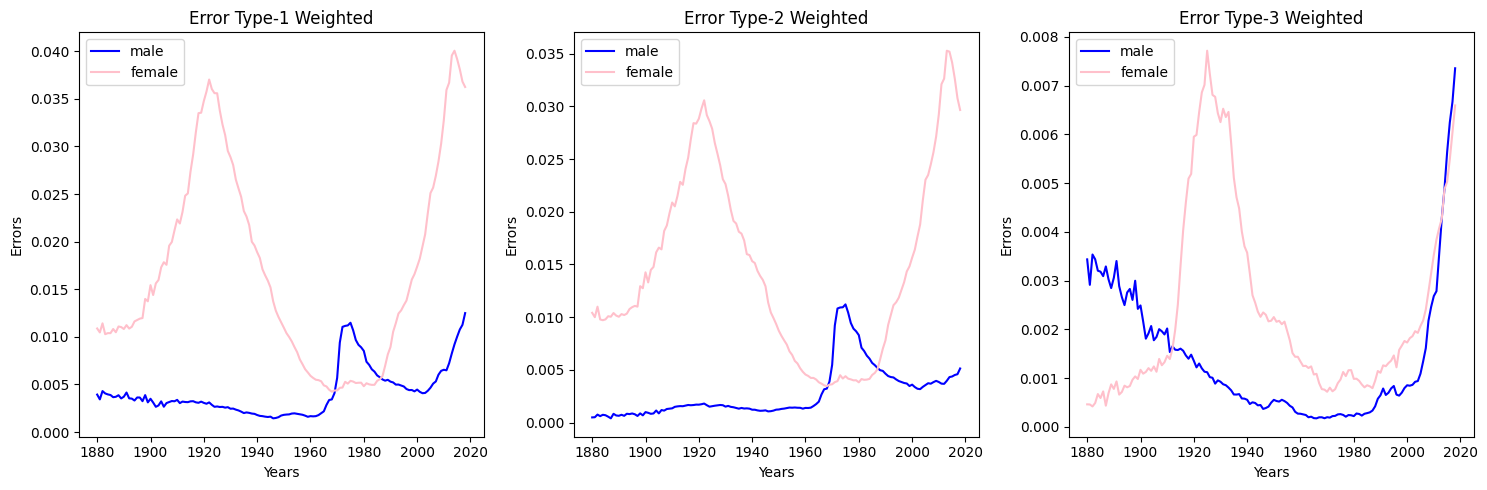

In [ ]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts
# Defining template index.
template_idx = 8

# Defining list variables.
type1_errors_male = []
type1_errors_female = []

type2_errors_male = []
type2_errors_female = []

type3_errors_male = []
type3_errors_female = []

for year in years:
    # Getting the errors.
    male_errs = ner_inference_errors(year, "male", template_idx)
    female_errs = ner_inference_errors(year, "female", template_idx)

    # Appending the corresponding lists.
    type1_errors_male.append(male_errs[0])
    type2_errors_male.append(male_errs[1])
    type3_errors_male.append(male_errs[2])
    type1_errors_female.append(female_errs[0])
    type2_errors_female.append(female_errs[1])
    type3_errors_female.append(female_errs[2])

# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

# TODO. 3pts
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot for Type-1 weighted error
sns.lineplot(x=years, y=type1_errors_male, label="male", color="blue", ax=ax[0])
sns.lineplot(x=years, y=type1_errors_female, label="female", color="pink", ax=ax[0])
ax[0].set_title("Error Type-1 Weighted")
ax[0].set_xlabel("Years")
ax[0].set_ylabel("Errors")
ax[0].legend()

# Plot for Type-2 weighted error
sns.lineplot(x=years, y=type2_errors_male, label="male", color="blue", ax=ax[1])
sns.lineplot(x=years, y=type2_errors_female, label="female", color="pink", ax=ax[1])
ax[1].set_title("Error Type-2 Weighted")
ax[1].set_xlabel("Years")
ax[1].set_ylabel("Errors")
ax[1].legend()

# Plot for Type-3 weighted error
sns.lineplot(x=years, y=type3_errors_male, label="male", color="blue", ax=ax[2])
sns.lineplot(x=years, y=type3_errors_female, label="female", color="pink", ax=ax[2])
ax[2].set_title("Error Type-3 Weighted")
ax[2].set_xlabel("Years")
ax[2].set_ylabel("Errors")
ax[2].legend()

plt.tight_layout()
plt.show()

## Template 9 Analysis

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


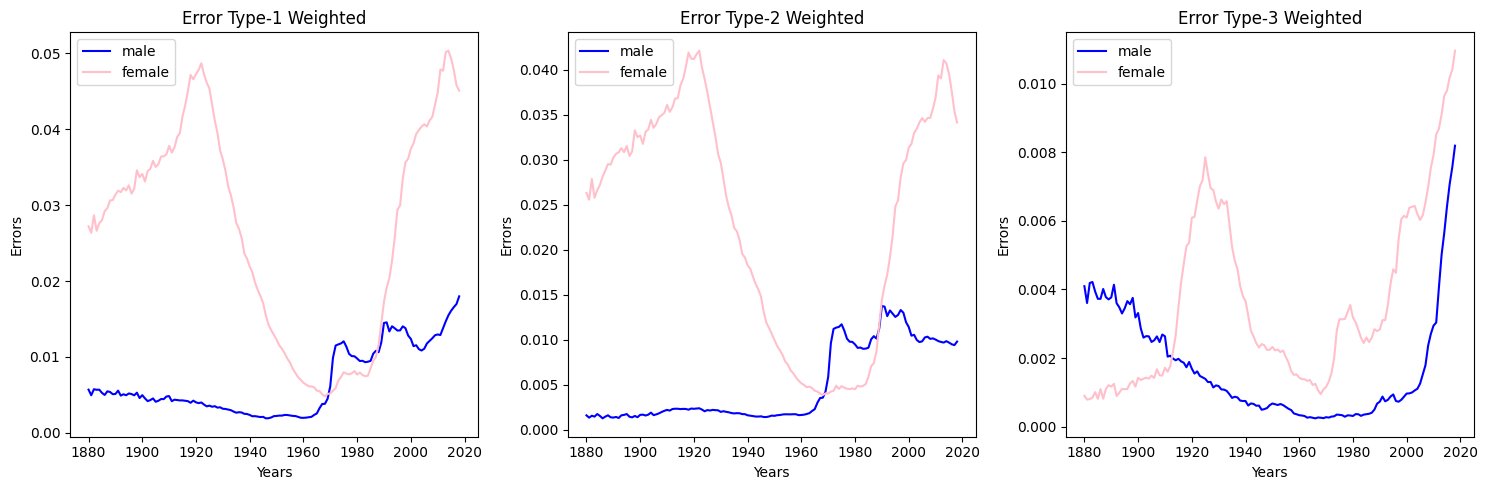

In [ ]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts
# Defining template index.
template_idx = 9

# Defining list variables.
type1_errors_male = []
type1_errors_female = []

type2_errors_male = []
type2_errors_female = []

type3_errors_male = []
type3_errors_female = []

for year in years:
    # Getting the errors.
    male_errs = ner_inference_errors(year, "male", template_idx)
    female_errs = ner_inference_errors(year, "female", template_idx)

    # Appending the corresponding lists.
    type1_errors_male.append(male_errs[0])
    type2_errors_male.append(male_errs[1])
    type3_errors_male.append(male_errs[2])
    type1_errors_female.append(female_errs[0])
    type2_errors_female.append(female_errs[1])
    type3_errors_female.append(female_errs[2])

# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

# TODO. 3pts
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot for Type-1 weighted error
sns.lineplot(x=years, y=type1_errors_male, label="male", color="blue", ax=ax[0])
sns.lineplot(x=years, y=type1_errors_female, label="female", color="pink", ax=ax[0])
ax[0].set_title("Error Type-1 Weighted")
ax[0].set_xlabel("Years")
ax[0].set_ylabel("Errors")
ax[0].legend()

# Plot for Type-2 weighted error
sns.lineplot(x=years, y=type2_errors_male, label="male", color="blue", ax=ax[1])
sns.lineplot(x=years, y=type2_errors_female, label="female", color="pink", ax=ax[1])
ax[1].set_title("Error Type-2 Weighted")
ax[1].set_xlabel("Years")
ax[1].set_ylabel("Errors")
ax[1].legend()

# Plot for Type-3 weighted error
sns.lineplot(x=years, y=type3_errors_male, label="male", color="blue", ax=ax[2])
sns.lineplot(x=years, y=type3_errors_female, label="female", color="pink", ax=ax[2])
ax[2].set_title("Error Type-3 Weighted")
ax[2].set_xlabel("Years")
ax[2].set_ylabel("Errors")
ax[2].legend()

plt.tight_layout()
plt.show()

### According to the plots you make, do you observe difference in the ability to recognize male and female names as PERSON entity types? How does the difference change over years? How does the difference change across different templates? Checking some error cases, where do you think the bias might come from? Can you think of any possible ways to mitigate the bias? 10pts.

#### <font color="red">Please type your response here.</font>
#### Responses

### Difference in Recognizing Names:   

1) Female names have in general a higher error rates than male names across all templates, showing NER models are less accurate for female names.   

2) Female names are often misclassified as non-PERSON (e.g., locations) or not tagged at all.   

### Change Over Years:    

1) Error rates fluctuate, and the gap between male and female errors mostly tend to reduce during the late 1900s (for eg. 1960-1990), for type-1 and type-2 errors. And for type-3, the gap between male and female errors tend to be lesser during the initial 1900s.   

2) Also, the overall trend for female and male errors show that the errors have generally increased for both males and females over the years.   
   
### Change Across Templates:   

1) Contextual templates (e.g., "<Name> is a nurse") reduce errors, but female names still have higher errors. Non-contextual templates (e.g., just "<Name>") confuse models more and result in higher error values as compared to other templates.

### Possible Sources of Bias:

1) Societal Bias: Historical societal biases (e.g., men receiving more education) may influence models.   

3) Model Updates: Newer model versions sometimes amplify bias, misclassifying more female names.   

4) Name Ambiguity: Some female names (e.g., "Charlotte") are also location names, confusing models.

### Ways to Mitigate Bias:

1) Contextual Models: Use models like Flair that leverage context to reduce errors.

2) Bias Benchmarks: Use benchmarks to evaluate and address bias during model development.

3) Debiasing Techniques: Apply debiasing methods to reduce gender-specific biases.

4) Regular Audits: Test models for biases, especially after updates.

5) Real-World Corpora: Train models on real-world text to improve robustness.

<center><b>***** End of Document *****</b></center>